## How to access this in Colab
본 실습에서는 모델 학습 단에서 DICOM원본을 받기에는 용량에 한계가 있어, PNG파일을 활용합니다.
1. 개인 google drive에 폴더를 생성해주세요.
2. 이 ipynb 파일과 아래 링크에서 data, dense_ckpt01 폴더를 받아서 같은 디렉토리에 저장해주세요.  
https://drive.google.com/drive/folders/19QLnvMjG4iAbvxq7s3xjYD43keN6kHzK?usp=sharing

In [ ]:
#mount google drive to read data
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
%cd '/content/drive/My Drive/CT'

In [ ]:
!pip install pydicom

---

# **Handling CT**
본 notebook은 아래의 코드를 참고하였습니다:
- Notebook by Guido Zuidhof : https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
- Notebook by Alexandr Moskalev : https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing/comments

## 목차
- **DICOM 파일 불러오기**
- **DICOM pixel array를 Hounsfield Units (HU)으로 변환**
- **CT windowing**
- **Resampling**

## Outline
- <a href='#CT_data'>**About data**</a>
    - <a href='#CT_image_folder'>`About image folder`</a>
    - <a href='#CT_dicom'>`About DICOM file`</a>
- <a href='#CT_work_dicom'>**Working with CT images**</a>
    - <a href='#CT_image'>`Image-wise steps`</a>
        - Step1: Control file meta information
        - Step2-1: Control dicom image
        - Step2-2: Transforming to Hounsfield Units
        - Step2-3: Image windowing
    - <a href='#CT_slice'>`Slice-wise steps`</a>
        - Step1-1: Load CT-scans per patient
        - Step1-2: Visualize
        - Step2: Slices windowing
    - <a href='#CT_voxel'>`Voxel-wise steps`</a>
        - Step1: The voxel size
        - Step2: Slice thickness
        - Step3: Resampling the voxel size

<a id='CT_data'></a>
# **About data**
본 실습에서 사용할 CT 데이터셋은 kaggle에 공개되어 있는 `RSNA Pulmonary Embolism Detection` 흉부 CT 데이터셋입니다.

### RSNA Pulmonary Embolism Detection Challenge Terms of Use and Attribution

You may access and use these de-identified imaging datasets and annotations (“the data”) for non-commercial purposes only, including academic research and education, as long as you agree to abide by the following provisions:
1. Not to make any attempt to identify or contact any individual(s) who may be the subjects of the data.
2. If you share or re-distribute the data in any form, include a citation to the “RSNA-STR Pulmonary Embolism CT (RSPECT) Dataset, Copyright RSNA, 2020” and provide a link to this download site:

        https://www.rsna.org/education/ai-resources-and-training/ai-image-challenge/rsna-pe-detection-challenge-2020

<a id='CT_image_folder'></a>
## `About image folder`
- `RSNA Pulmonary Embolism Detection` 데이터셋의 디렉토리 구성은 다음과 같습니다: `<StudyInstanceUID>/<SeriesInstanceUID>/<SOPInstanceUID>.dcm`  
  (* *주의: 데이터셋마다 디렉토리 구성은 차이가 있습니다.*)
- Example
    - `<StudyInstanceUID>` : 0a4d7c9fa082
    - `<SeriesInstanceUID>` : 38eddda9207f
    - `<SOPInstanceUID>.dcm` : c7a7ad9160f5.dcm

In [18]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pydicom
import matplotlib.pyplot as plt

In [19]:
FILE_EXTENSION = ['.img', '.IMG', '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', \
                  '.PNG', '.gif', '.GIF', 'dcm', 'DCM', '.csv', '.CSV']
DCM_EXTENSION = ['.dcm', '.DCM']
IMG_EXTENSION = ['.img', '.IMG', '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.gif', '.GIF']

def check_extension(filename, extension_ls=FILE_EXTENSION):
    # filename이 해당 확장자(extension_ls)로 되어있는 경우 True
    return any(filename.endswith(extension) for extension in extension_ls)

def load_file_paths(folder_path, extension_ls=FILE_EXTENSION):
    """
    find 'extension_ls' file paths in folder.
    
    Parameters:
        folder_path (str) -- folder directory
        extension_ls (list) -- list of extensions
    
    Return:
        file_paths (list) -- list of 'extension_ls' file paths
    
    """
    
    file_paths = []
    assert os.path.isdir(folder_path), f'{folder_path} is not a valid directory'

    for root, _, fnames in sorted(os.walk(folder_path)):
        for fname in fnames:
            if check_extension(fname, extension_ls):
                path = os.path.join(root, fname)
                file_paths.append(path)
 
    return file_paths[:]

In [20]:
DATA_PATH = "./data/rsna-str-pulmonary-embolism-detection/train"

dcm_file_paths = load_file_paths(DATA_PATH, DCM_EXTENSION)

In [21]:
dcm_file_paths

['./data/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082/38eddda9207f/d12832a23a42.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082/38eddda9207f/c920a23b40c8.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082/38eddda9207f/c7a7ad9160f5.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/10d5afcc6c55/18798a4cdfd4/fffd639044cc.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/10d5afcc6c55/18798a4cdfd4/67d6288b2a7b.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/10d5afcc6c55/18798a4cdfd4/66e80f76f648.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/78a48d0c1337/0fa5fa6463e7/ff4814bbe324.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/78a48d0c1337/0fa5fa6463e7/aca3ebf018f1.dcm',
 './data/rsna-str-pulmonary-embolism-detection/train/78a48d0c1337/0fa5fa6463e7/bcc83b2ec5da.dcm']

<a id='CT_dicom'></a>
## `About DICOM file`
DICOM 파일은 영상과 영상의 info가 저장된 DICOM Header로 구성되어 있습니다.  
Python에서 DICOM 파일은 `pydicom` package를 통해 열어볼 수 있습니다.

In [22]:
example_path = dcm_file_paths[0] # select a img path form path list

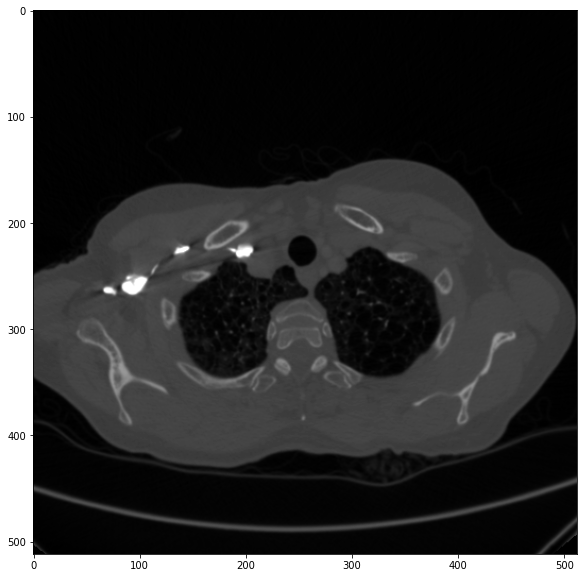

In [23]:
# pydicom으로 dicom 열기
# DICOM Header & Image
dcm_info = pydicom.read_file(example_path, force=True) # reading even if no File Meta Information header is found
dcm_img = dcm_info.pixel_array

plt.figure(figsize=(10,10))
plt.imshow(dcm_img, cmap='gray')

In [24]:
print(dcm_info)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.255888651754624732269098324029827330740.1
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.2'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: d12832a23a42
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice

___

<a id='CT_work_dicom'></a>
# **Working with CT images**
DICOM 파일 안에 있는 CT 영상은 단순히 pixel_array로 불러오기만 하면 안됩니다.  
3 steps를 통해 CT 영상을 온전히 다루는 방법에 대해 설명하고자 합니다.
- Image-wise steps
- Slice-wise steps
- Voxel-wise steps

<a id='CT_image'></a> 
## `Image-wise steps`

### Step1: Control file meta information
DICOM Header의 요소를 개별적으로 불러오는 방법은 여러가지가 있습니다.

In [25]:
print("Slice Thickness: {}".format(dcm_info.SliceThickness)) #Instance
print("Rescale Intercept: {}".format(dcm_info[0x0028, 0x1052].value)) #hexadecimal
print("Rescale Slope: {}".format(dcm_info.get("RescaleSlope"))) #get
#pydicom.read_file은 dicom을 dict 기반 형태로 불러오기 때문에 get 메소드를 쓸 수 있습니다.

Slice Thickness: 1.25
Rescale Intercept: -1024
Rescale Slope: 1


### Step2-1: Control dicom image
pydicom.read_file을 통해 불러온 인스턴스.pixel_array에 영상이 저장되어 있습니다.

In [26]:
# Extract image(np.array) from DICOM 

In [27]:
dcm_img = dcm_info.pixel_array

In [28]:
# image size(height width), image datatype, pixel datatype
dcm_img.shape, type(dcm_img), dcm_img.dtype

((512, 512), numpy.ndarray, dtype('uint16'))

In [29]:
# pixel value min max
np.min(dcm_img), np.max(dcm_img)

(0, 4000)

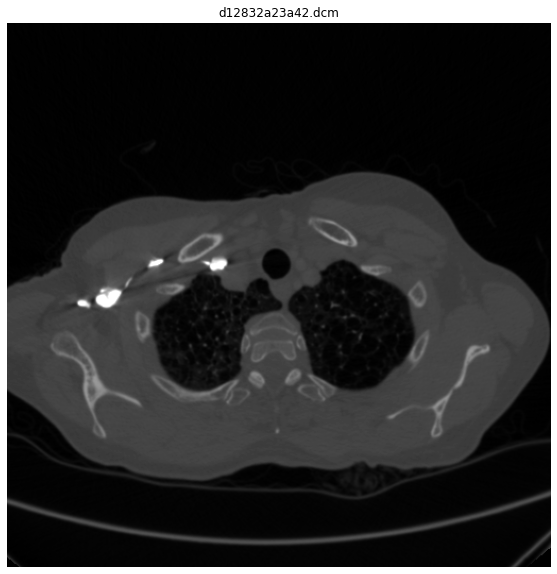

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(dcm_img, cmap='gray')
plt.axis("off")
plt.title(example_path.split('/')[-1])
plt.show()

### Step2-2: Transforming to Hounsfield Units
CT 영상은 기본적으로 Houndsfield Unit(HU)으로 정의됩니다.  
하지만 불러온 pixel_array는 HU값으로 되어있지 않기 때문에  
영상의 pixel값을 HU로 변환하는 과정이 필요합니다.

![HU](sample/HU.png)

reference: https://youtu.be/4pb1f79h7_I

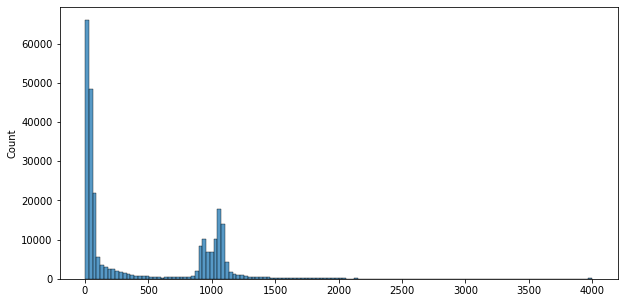

In [31]:
#Intensity histogram
plt.figure(figsize=(10,5))
sns.histplot(dcm_img.flatten())
plt.show()

#### Rescale Intercept / Rescale Slope
:  CT images, whose pixel values are measured in Hounsfield units, which can have negative values, are "commonly" stored with an `unsigned integer`
$$
U = m*SV + b
$$

- $U$ : output units
- $m$ : rescale slope(0028|1053)
- $SV$ : stored value
- $b$ : rescale intercept(0028|1052)

reference: https://blog.kitware.com/dicom-rescale-intercept-rescale-slope-and-itk/

In [32]:
# 벤더에 따라 CT recon을 원형으로 하는 경우가 있는데,
# 이 때 원형 밖에 있는 부분은 padding을 하게 됩니다. 
# padding 값은 보통 HU범위 밖에 있는 값으로 지정합니다.
# DICOM Header의 Pixel Padding Value Attribute(0028,0120) 참고.

In [33]:
def set_outside_scanner_to_air(hu_pixelarrays):
    """
    Pixel Padding Value Attribute(0028,0120) -> air
    """
    hu_pixelarrays[hu_pixelarrays < -1024] = -1024 
    
    return hu_pixelarrays

In [34]:
def transform_to_hu(dicom_info, image):
    """
    transform pixel_array value to HU
    
    Parameters:
        dicom_info (PydicomDataset) -- DICOM Dataset (derived from python’s dict)
        image (np.array) -- DICOM pixel_array
    
    Return:
        hu_image (np.array) -- HU image
    
    """
    image = set_outside_scanner_to_air(image)
    
    intercept = dicom_info.RescaleIntercept
    slope = dicom_info.RescaleSlope
    hu_image = image.astype(np.float64) * slope + intercept
    hu_image = set_outside_scanner_to_air(hu_image.astype(np.int16))
    return hu_image

In [35]:
ct_img = transform_to_hu(dcm_info, dcm_img)

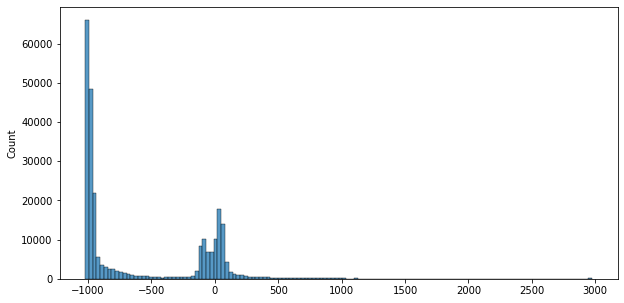

In [36]:
#Intensity histogram
plt.figure(figsize=(10,5))
sns.histplot(ct_img.flatten())
plt.show()

#### Pixel Padding Value Attribute(0028,0120)가 존재하는 case

![pixel_padd](sample/set_outside_scanner.png)

### Step2-3: Image windowing
CT 영상은 HU를 기준으로 특정 영역(lung, bone,..)만을 관심 영역으로 하여  
contrast를 높일 수 있습니다. 이를 CT image windowing라고 합니다.

![window](sample/window.jpg)

reference: http://www.sprawls.org/resources/DIGPROCESS/module.htm

In [37]:
class CT_Windowing:
    """
    CT image windowing : WL_Window Level, WW_Window Width
    """
   
    def __init__(self, mode='custom', custom_window=None, norm=False):
        """
        Parameters:
            mode (str)(WL|WW) -- 
                'abdomen'(60|400) , 'bone'(300|1500), 'brain'(40|80), 
                'chest'(40|400), 'lung'(-700|1500), 'custom'(WL|WW)
            custom_window (list or tuple) -- 
                if mode == 'custom', set custom_window(WL, WW)
            norm (bool) -- normalize to uint8 (0~255)

        """
        option = ['abdomen' , 'bone', 'brain', 'chest', 'lung', 'custom']
        assert mode in option, "Wrong mode: Enter \'abdomen\' , \'bone\', \
                                \'brain\', \'chest\', \'lung\', \'custom\'"
        
        self.mode = "window_" + mode
        if custom_window is not None:
            self.w_level = custom_window[0]
            self.w_width = custom_window[1]
            
        self.norm = norm
        
    def windowing(self):
        self.w_min = self.w_level - (self.w_width / 2)
        self.w_max = self.w_level + (self.w_width / 2)
        window_image = self.img.copy()
        window_image[window_image < self.w_min] = self.w_min
        window_image[window_image > self.w_max] = self.w_max
        
        if self.norm:
            window_image = np.uint8(((window_image - self.w_min) / \
                                     (self.w_max - self.w_min)) * 255.0)
        return window_image
        
    def window_abdomen(self):
        self.w_level = 60
        self.w_width = 400
        
        return self.windowing()
        
    def window_bone(self):
        self.w_level = 300
        self.w_width = 1500
        
        return self.windowing()
    
    def window_brain(self):
        self.w_level = 40
        self.w_width = 80
        
        return self.windowing()
    
    def window_chest(self):
        self.w_level = 40
        self.w_width = 400
        
        return self.windowing()
        
    def window_lung(self):
        #SNUH version
        self.w_level = -700
        self.w_width = 1500
        #print('lung')
        return self.windowing()
        
    def window_custom(self):
        return self.windowing()
    
    def __call__(self, hu_img):
        self.img = hu_img
        self.opt = getattr(self, self.mode, lambda:'custom')
        return self.opt()  

In [38]:
lung_window_fn = CT_Windowing(mode='lung', norm=True)
lungw_img = lung_window_fn(ct_img)

(-0.5, 511.5, 511.5, -0.5)

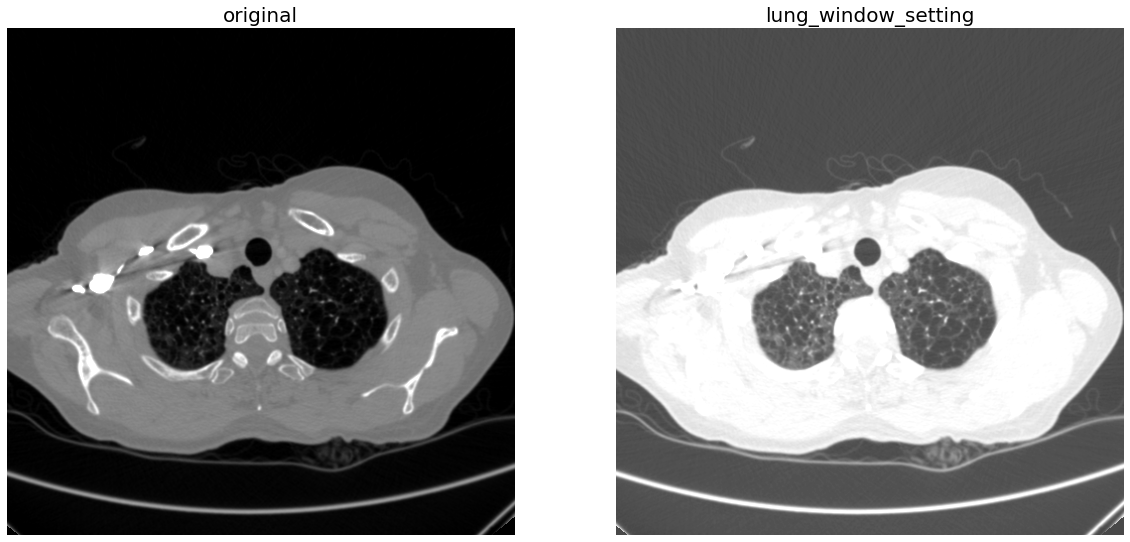

In [39]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(ct_img, vmin=-1000, vmax=1000,cmap="gray")
ax[0].set_title('original', fontsize=20)
ax[0].axis("off")
ax[1].imshow(lungw_img, vmin=0, vmax=255, cmap='gray')
ax[1].set_title('lung_window_setting', fontsize=20)
ax[1].axis("off")

<a id='CT_slice'></a> 
### `Slice-wise steps`

### Step1: Load CT-scans per patient
CT 영상은 단일 slide가 아닌, 여러개의 slide로 구성되어 있습니다.  
위에서 정리했던 내용을 총합하여 한 폴더(case) 내에 있는 모든 dicom slide를  
불러오는 function을 제시합니다.

In [40]:
TEST_PATH = "./data/rsna-str-pulmonary-embolism-detection/test/0a5dc64cf7b8"

In [53]:
def load_ct_scans(patient_folder_path):
    """
    Function of Loading CT-scans "per patient"
    patient path to CT slices(HU)
    Parameters:
        patient_folder_path (str) -- case folder directory
        
    Return:
        slices[0] (PydicomDataset) -- DICOM Info
        hu_images (list) -- list of CT images(HU)
        
    """
    # call all image paths in directory
    dcm_paths = load_file_paths(patient_folder_path, DCM_EXTENSION)
    
    slices = [pydicom.read_file(dcm_path, force=True) for dcm_path in dcm_paths]
    
    # **Sort the slices in ascending order
    # 폴더 내 dcm파일이 순차적으로 정렬되있으리라는 보장이 없기 때문에 정렬을 해줍니다.
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]), reverse=True)
    
    # stack slices
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    
    # convert to HU
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    
    # return header of first dicom and stacked CT slices
    return slices[0], hu_images

In [54]:
_, test_imgs = load_ct_scans(TEST_PATH)

In [55]:
test_imgs.shape # (# of slices, row, col)

(220, 512, 512)

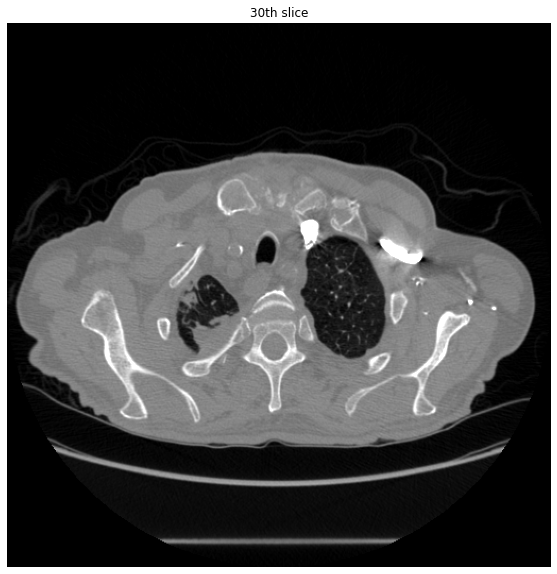

In [56]:
# show 30th slice
K_th = 30
plt.figure(figsize=(10,10))
plt.imshow(test_imgs[K_th-1], vmin= -1000, vmax=1000, cmap='gray')
plt.title('{}th slice'.format(K_th))
plt.axis("off")
plt.show()

### Step1-2: Visualize

In [57]:
# wrong case
# plt.imshow는 자동적으로 pixel value를 normalize하기 때문에
# HU같이 min max값이 정해져 있는 경우, parameter 설정을 해줘야합니다.

In [60]:
def w_sample_stack(stack, rows=6, cols=6, start_with=0, show_every=1):
    """
    plt.imshow
    By default, a linear scaling mapping the lowest value to 0 
    and the highest to 1 is used.
    
    """
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title(f'slice {ind}')
        
        ax[int(i/cols),int(i % cols)].imshow(stack[ind],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

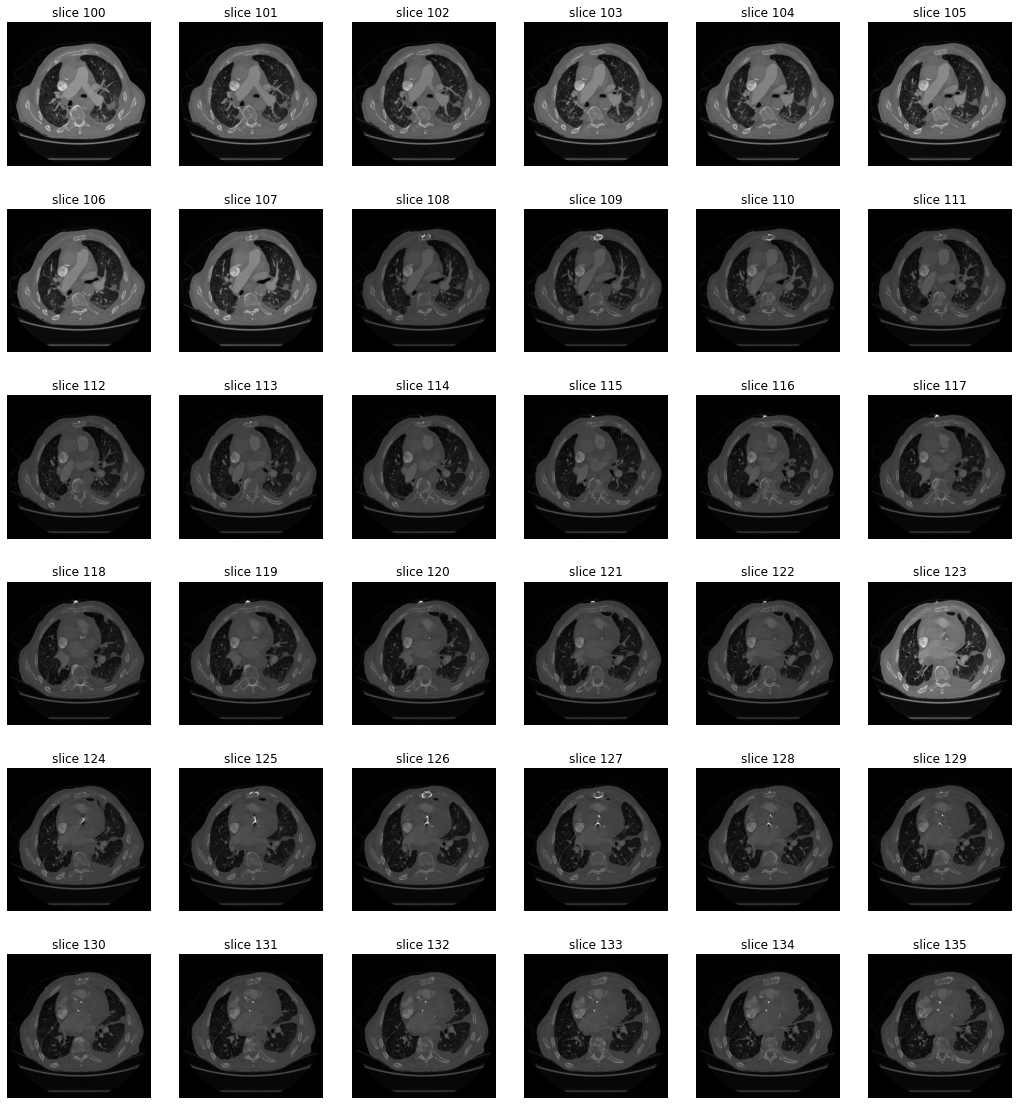

In [61]:
w_sample_stack(test_imgs)

In [62]:
# solution

In [63]:
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=1, vmin=-1000, vmax=1000):
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title(f'slice {ind}')
        ax[int(i/cols),int(i % cols)].imshow(stack[ind], vmin=vmin, vmax=vmax,cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

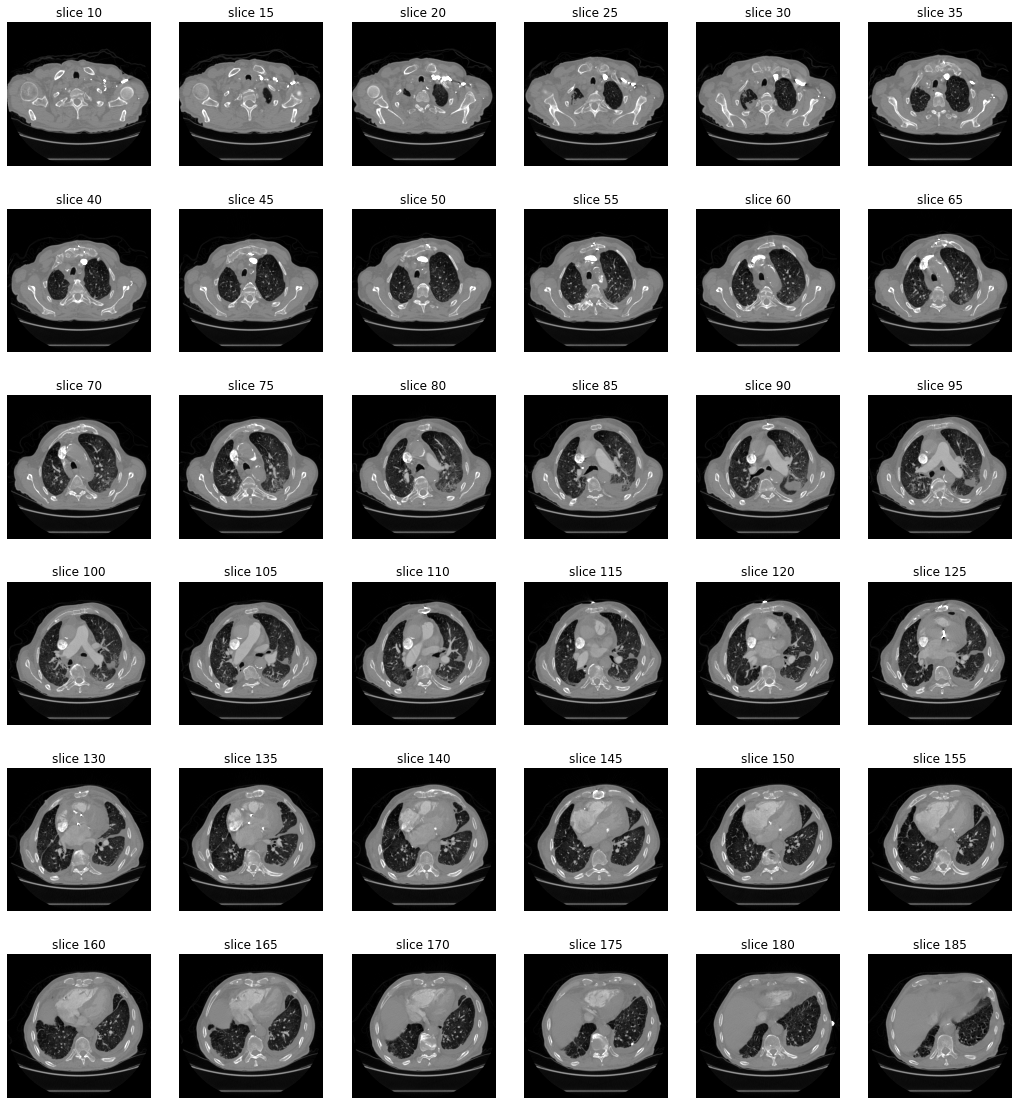

In [64]:
sample_stack(test_imgs)

### Step2: Slices Windowing
앞서 구현했던 ct windowing function은 여러 slide에도 동작할 수 있게끔  
되어 있습니다.

In [65]:
lung_window_fn = CT_Windowing(mode='lung', norm=True) # norm=True : [0,255]
lungw_imgs = lung_window_fn(test_imgs)

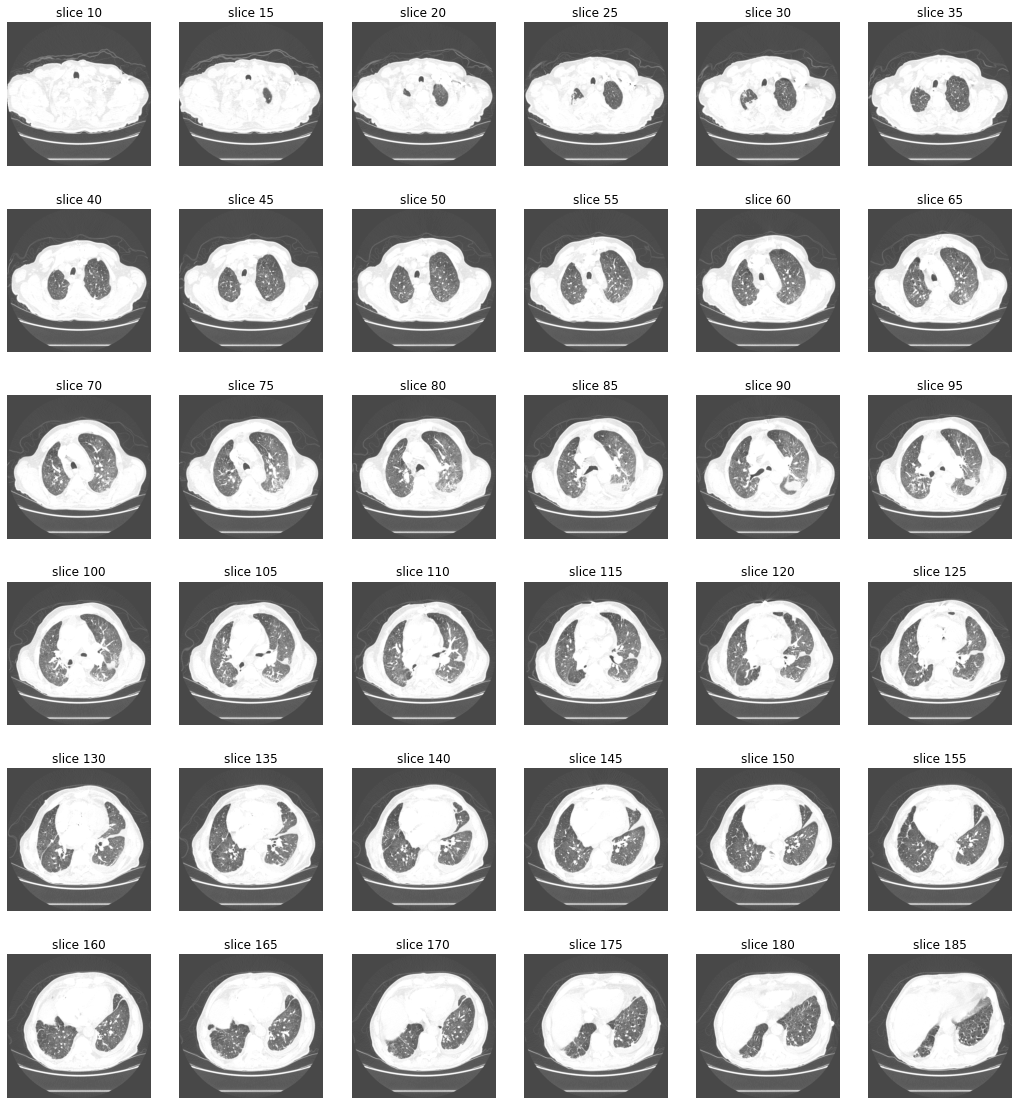

In [66]:
sample_stack(lungw_imgs, vmin=0, vmax=255)

<a id='CT_voxel'></a> 
### `Voxel-wise steps`
CT를 전체 slice에 대해 살펴봤다면,  
각각의 CT cases를 비교할 때 필요한 info에 대해 소개하려 합니다.
특히 공간적 정보에 대해 다뤄볼 것입니다.
- Pixel spacing: x, y-axis
- Slice thickness: z-axis

### Step1: Pixelspacing
- DICOM 파일에서 찾을 수 있는 pixel spacing 특성은 중요한 특성입니다. 1픽셀에 해당하는 물리적인 거리를 알려줍니다. 
- 한 환자(case)의 경우 이 pixel spacing은 일반적으로 모든 슬라이스에서 동일합니다.
- 그러나 환자 간 pixel spacing은 병원의 protocol에 따라 다를 수 있으며 스캐너 유형에 따라 달라질 수도 있습니다. 따라서 폐의 크기로 두 이미지를 비교한다고 해서 장기의 물리적 크기가 더 큰 것은 아닙니다.

![pixelspacing](sample/pixelspacing.png)

reference: https://simpleitk.readthedocs.io/en/v1.2.4/Documentation/docs/source/fundamentalConcepts.html

`RSNA Pulmonary Embolism Detection` 전체 데이터셋에 대해 pixel spacing를 포함한 DICOM Header info를 DataFrame 형태로 저장하여 분석에 용이하게 만들 수 있습니다. 참고로 이 데이터셋은 학습 데이터 수가 7279cases(대략 900GB)입니다.

In [72]:
DATA_PATH = "./data/rsna-str-pulmonary-embolism-detection/train"

train_dcm_paths = load_file_paths(DATA_PATH, DCM_EXTENSION)

In [74]:
# sample database
uid = [uid.split('.')[-2].split('/')[-3:] for uid in train_dcm_paths]
train_df_sample = pd.DataFrame(data=uid, columns=["StudyInstanceUID","SeriesInstanceUID","SOPInstanceUID"])
train_df_sample["folder_path"] = DATA_PATH + "/" + train_df_sample.StudyInstanceUID + "/" + train_df_sample.SeriesInstanceUID

In [75]:
train_df_sample

StudyInstanceUID SeriesInstanceUID SOPInstanceUID  \
0     0a4d7c9fa082      38eddda9207f   d12832a23a42   
1     0a4d7c9fa082      38eddda9207f   c920a23b40c8   
2     0a4d7c9fa082      38eddda9207f   c7a7ad9160f5   
3     10d5afcc6c55      18798a4cdfd4   fffd639044cc   
4     10d5afcc6c55      18798a4cdfd4   67d6288b2a7b   
5     10d5afcc6c55      18798a4cdfd4   66e80f76f648   
6     78a48d0c1337      0fa5fa6463e7   ff4814bbe324   
7     78a48d0c1337      0fa5fa6463e7   aca3ebf018f1   
8     78a48d0c1337      0fa5fa6463e7   bcc83b2ec5da   

                                         folder_path  
0  ./data/rsna-str-pulmonary-embolism-detection/t...  
1  ./data/rsna-str-pulmonary-embolism-detection/t...  
2  ./data/rsna-str-pulmonary-embolism-detection/t...  
3  ./data/rsna-str-pulmonary-embolism-detection/t...  
4  ./data/rsna-str-pulmonary-embolism-detection/t...  
5  ./data/rsna-str-pulmonary-embolism-detection/t...  
6  ./data/rsna-str-pulmonary-embolism-detection/t...  
7  ./data/rsna-str-pulmonary-embolism-detection/t...  
8  ./data/rsna-str-pulmonary-embolism-detection/t...

In [77]:
# sample function
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

# 모든 cases에 대해 DCM Header info를 추출
pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
patient_id = []
patient_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []


patients = train_df_sample.SeriesInstanceUID.unique()[0:N]

for patient in patients:
    patient_id.append(patient)
    
    path = train_df_sample[train_df_sample.SeriesInstanceUID == patient].folder_path.values[0]
    example_dcm = os.listdir(path)[0]
    patient_pth.append(path)
    dataset = pydicom.dcmread(path + "/" + example_dcm)
    
    # extract info
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    
    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])
    
scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "patient_pth"] = patient_pth

scan_properties.head()

patient  rows  columns    area  pixelspacing_r  pixelspacing_c  \
0  38eddda9207f   512      512  262144        0.632812        0.632812   
1  18798a4cdfd4   512      512  262144        0.519531        0.519531   
2  0fa5fa6463e7   512      512  262144        0.707031        0.707031   

   pixelspacing_area  slice_thickness  \
0           0.400452             1.25   
1           0.269913             1.25   
2           0.499893             1.25   

                                         patient_pth  
0  ./data/rsna-str-pulmonary-embolism-detection/t...  
1  ./data/rsna-str-pulmonary-embolism-detection/t...  
2  ./data/rsna-str-pulmonary-embolism-detection/t...

In [81]:
# real data distribution
# 전체 dataset에 대해 info를 추출한 csv파일을 불러옵니다.

In [82]:
dicom_headers = pd.read_csv("./data/rsna-str-pulmonary-embolism-detection/rsna-pulmonary-embolism-dicom-header-data.csv")

In [83]:
dicom_headers.pixelspacing_r

0       0.871094
1       0.683594
2       0.618000
3       0.683594
4       0.691406
          ...   
7274    0.671875
7275    0.666016
7276    0.648438
7277    0.741000
7278    0.781250
Name: pixelspacing_r, Length: 7279, dtype: float64

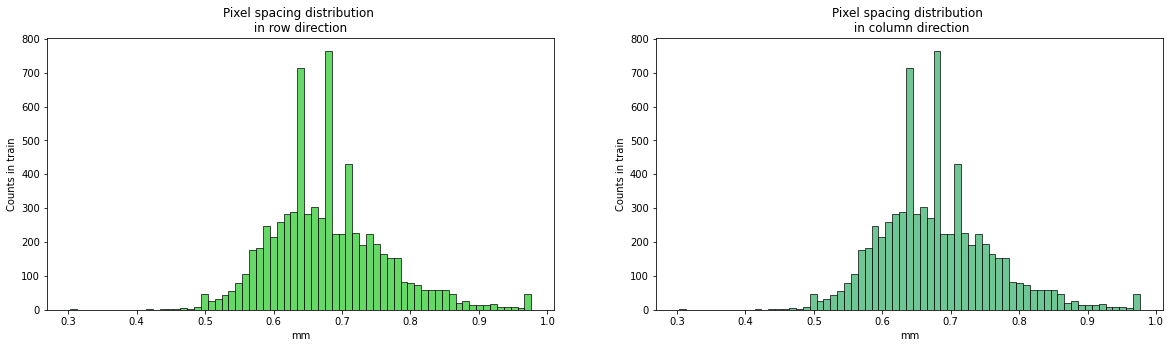

In [84]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(dicom_headers.pixelspacing_r.values, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("mm")
sns.histplot(dicom_headers.pixelspacing_c.values, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("mm");

위에서 볼 수 있듯이 pixelspacing 값은 case마다 조금씩 다른 것을 볼 수 있습니다.  
본 데이터셋은 0.6 ~ 0.7mm가 가장 많은 것을 확인할 수 있습니다.

### Step2: Slice thickness
slice의 두께도 중요합니다. 두께가 두꺼울수록 픽셀이 갖는 정보가 더 많아지기 때문에,
해상도는 떨어집니다. 본 데이터셋은 1.5mm Slice thickness가 가장 많습니다.

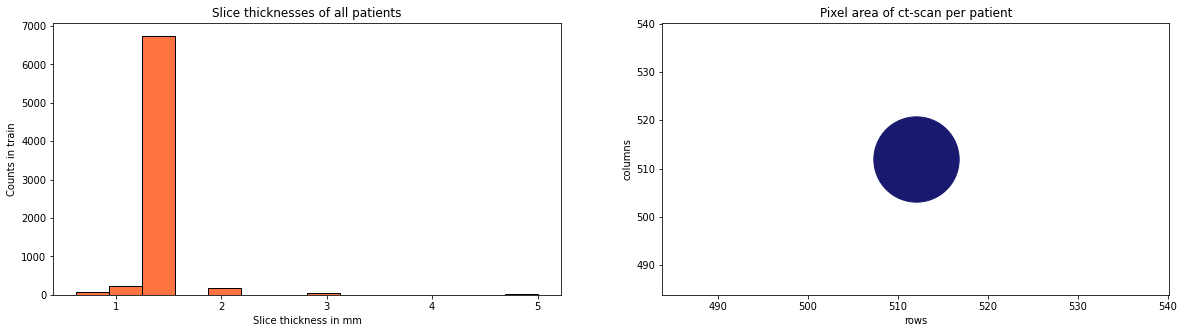

In [140]:
counts = dicom_headers.groupby(["rows", "columns"]).size()
counts = counts.unstack()
counts.fillna(0, inplace=True)


fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(dicom_headers.slice_thickness.values, color="orangered", kde=False, ax=ax[0])
ax[0].set_title("Slice thicknesses of all patients");
ax[0].set_xlabel("Slice thickness in mm")
ax[0].set_ylabel("Counts in train");

for n in counts.index.values:
    for m in counts.columns.values:
        ax[1].scatter(n, m, s=counts.loc[n,m], c="midnightblue")
ax[1].set_xlabel("rows")
ax[1].set_ylabel("columns")
ax[1].set_title("Pixel area of ct-scan per patient");

In [86]:
thick_type_path1 = "./data/rsna-str-pulmonary-embolism-detection/train/0a4d7c9fa082"

In [87]:
ttpdatainfo1, ttp_imgs1 = load_ct_scans(thick_type_path1)

In [88]:
ttpdatainfo1.SliceThickness

"1.25"

In [89]:
thick_type_path2 = "./data/rsna-str-pulmonary-embolism-detection/test/62dfc5f411e8"

In [90]:
ttpdatainfo2, ttp_imgs2 = load_ct_scans(thick_type_path2)

In [91]:
ttpdatainfo2.SliceThickness

"2.0"

(-0.5, 511.5, 511.5, -0.5)

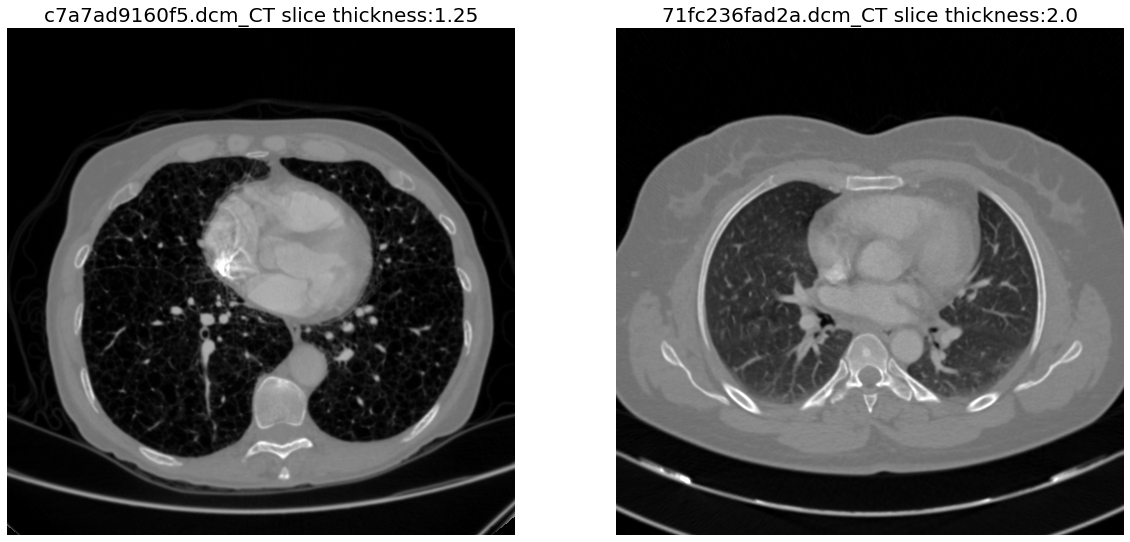

In [92]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(ttp_imgs1[0], vmin=-1000, vmax=1000, cmap="gray")
ax[0].set_title('{}.dcm_CT slice thickness:{}'.format(ttpdatainfo1[0x0008,0x0018].value, \
                                               ttpdatainfo1.SliceThickness), fontsize=20)
ax[0].axis("off")
ax[1].imshow(ttp_imgs2[0], vmin=-1000, vmax=1000, cmap='gray')
ax[1].set_title('{}.dcm_CT slice thickness:{}'.format(ttpdatainfo2[0x0008,0x0018].value, \
                                               ttpdatainfo2.SliceThickness), fontsize=20)
ax[1].axis("off")

### Step3: Resampling the voxel size
pixelspacing과 slice thickness가 약간 다를 때를 앞서 봤었는데,  
이는 case간의 절대적 크기가 중요한 경우 중요해집니다.
이런 경우에는 그 크기를 맞춰줄 필요가 있습니다.

In [93]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan.SliceThickness] + list(scan.PixelSpacing), dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    
    # recompute the resize factor and spacing such that we match the rounded new shape above
    rounded_resize_factor = new_shape / image.shape
    rounded_new_spacing = spacing / rounded_resize_factor
    
    # zoom with resize factor
    image = scipy.ndimage.interpolation.zoom(image, rounded_resize_factor, mode='nearest')
    
    return image, rounded_new_spacing

In [94]:
img_resampled, spacing = resample(ttp_imgs2, ttpdatainfo2, [1,1,1])
print("Shape before resampling\t", ttp_imgs2.shape)
print("Shape after resampling\t", img_resampled.shape)

Shape before resampling	 (1, 512, 512)
Shape after resampling	 (2, 347, 347)


Text(0.5, 1.0, 'Resampled: voxel_size [1,1,1]')

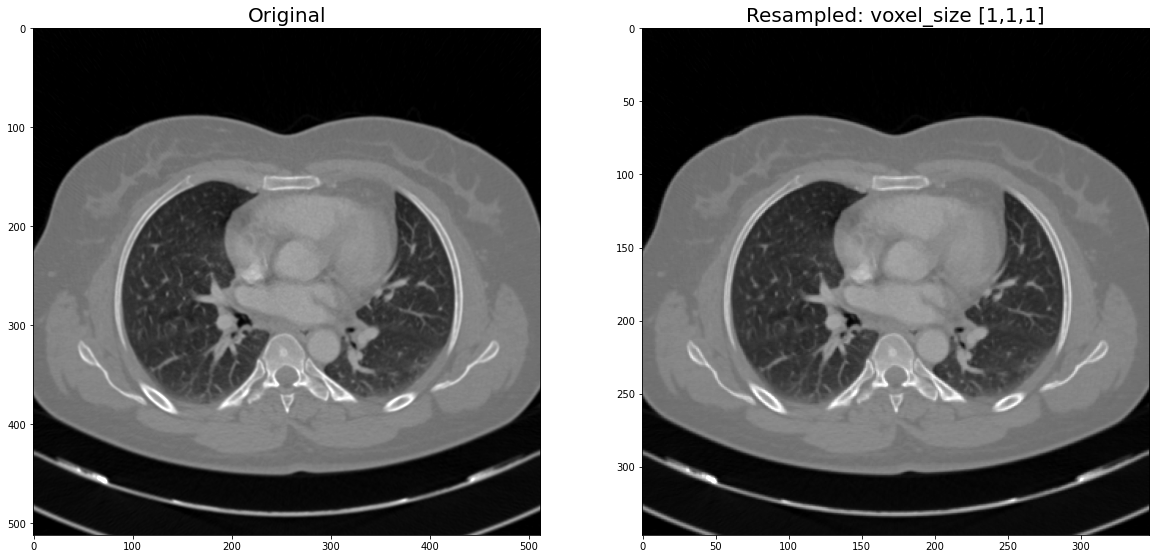

In [95]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(ttp_imgs2[0], vmin=-1000, vmax=1000, cmap="gray")
ax[0].set_title('Original', fontsize=20)
ax[1].imshow(img_resampled[0], vmin=-1000, vmax=1000, cmap='gray')
ax[1].set_title('Resampled: voxel_size [1,1,1]', fontsize=20)

___

# RSNA Intracranial Hemorrhage Detection
In this competition, your challenge is to build an algorithm to detect acute intracranial hemorrhage and its subtypes.

## Intracranial hemorrhage

![subtype](./sample/subtypes-of-hemorrhage.png)

본 실습에서는 kaggle의 'RSNA Intracranial Hemorrhage Detection' challenge의 `Brain CT 데이터셋`을 활용하여  
`CT의 각 slice를 Intracranial Hemorrhage의 총 5가지 subtype으로 분류하는 classification model` 구축을 진행합니다. 

## How to access this dataset?
본 실습에서는 모델 학습 단에서 DICOM원본을 받기에는 용량에 한계가 있어, PNG파일을 활용합니다.

In [ ]:
!unzip -qq "./data.zip"

# Opening
모델 구축에 앞서, 데이터가 어떤 구조로 이루어져있는지 그리고 데이터에 대한 EDA(Exploratory Data Analysis)가 필요합니다. 또한 모델 학습에 용이하도록 데이터를 전처리하는 과정도 요구됩니다.
- DATA INSIGHT
    - Datatype
        - <a href='#hemo_label'>Label</a>: CSV file
        - <a href='#hemo_Image_Folder'>Image Folder</a>: DICOM file

    - <a href='#hemo_image'>EDA</a>
    
- DATA PREPROCESSING
        

# DATA INSIGHT

In [6]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm

<a id='hemo_label'></a>
## Label
- 본 데이터셋은 CT 각 slide마다 다섯개의 subtypes의 유무가 라벨링되어 있습니다. (stage_2_train.csv)
- The probability of whether that sub-type of hemorrhage (or any hemorrhage in the case of any) exists in the indicated image.
- Subtypes
    - epidural_hemorrhage
    - intraparenchymal_hemorrhage
    - intraventricular_hemorrhage
    - subarachnoid_hemorrhage
    - subdural_hemorrhage
    - any (abnormal, binary)

In [10]:
!tree ./data/rsna-intracranial-hemorrhage-detection -L 1

./data/rsna-intracranial-hemorrhage-detection
├── data_png
├── stage_2_sample_submission.csv
├── stage_2_test
├── stage_2_train
├── stage_2_train.csv
├── stage_2_train.csv.tar.gz
├── train_metadata.csv
└── zip_unzip.ipynb

3 directories, 5 files


In [11]:
DATA_PATH = "./data/rsna-intracranial-hemorrhage-detection/"
os.listdir(DATA_PATH)

['stage_2_train.csv',
 'stage_2_train.csv.tar.gz',
 'stage_2_train',
 '.ipynb_checkpoints',
 'data_png',
 'stage_2_sample_submission.csv',
 'zip_unzip.ipynb',
 'stage_2_test',
 'train_metadata.csv']

In [12]:
train_label_df = pd.read_csv(os.path.join(DATA_PATH, "stage_2_train.csv"))

In [13]:
train_label_df.tail(6)

ID  Label
4516836          ID_4a85a3a3f_epidural      0
4516837  ID_4a85a3a3f_intraparenchymal      0
4516838  ID_4a85a3a3f_intraventricular      0
4516839      ID_4a85a3a3f_subarachnoid      0
4516840          ID_4a85a3a3f_subdural      0
4516841               ID_4a85a3a3f_any      0

- `ID` : `[Image Id]_[Sub-type Name]` 
- `Label` : `probability of whether that sub-type of hemorrhage`

### Data cleansing
Label을 바로 사용하지 않고 Label cleansing작업을 통해 정제합니다.

In [14]:
# 중복데이터 체크
total_num = len(train_label_df["ID"])
duplicate_num = len(train_label_df["ID"]) - len(train_label_df["ID"].unique())
print(f"전체 데이터 개수: {total_num}, 중복데이터 개수: {duplicate_num}")

전체 데이터 개수: 4516842, 중복데이터 개수: 24


In [15]:
# 중복 데이터 제거
train_label_df = train_label_df.drop_duplicates(ignore_index=True)

In [16]:
# 비어있는 데이터 체크
train_label_df.Label.isnull().sum()

0

In [17]:
train_label_df.tail(6)

ID  Label
4516812          ID_4a85a3a3f_epidural      0
4516813  ID_4a85a3a3f_intraparenchymal      0
4516814  ID_4a85a3a3f_intraventricular      0
4516815      ID_4a85a3a3f_subarachnoid      0
4516816          ID_4a85a3a3f_subdural      0
4516817               ID_4a85a3a3f_any      0

Label DataFrame을 학습에 용이하게 맞춰줍니다.

In [18]:
label = train_label_df.Label.values
train_label = train_label_df.ID.str.rsplit("_", n=1, expand=True)
train_label.loc[:, "label"] = label
train_label = train_label.rename({0: "id", 1: "subtype"}, axis=1)

In [19]:
train_label.tail(6)

id           subtype  label
4516812  ID_4a85a3a3f          epidural      0
4516813  ID_4a85a3a3f  intraparenchymal      0
4516814  ID_4a85a3a3f  intraventricular      0
4516815  ID_4a85a3a3f      subarachnoid      0
4516816  ID_4a85a3a3f          subdural      0
4516817  ID_4a85a3a3f               any      0

In [20]:
train_pivot = train_label.pivot(index="id", 
                                columns="subtype", 
                                values="label")
new_train_label_df = train_pivot.copy()
new_train_label_df.columns = new_train_label_df.columns.values
new_train_label_df.reset_index(level=0, inplace=True)

In [ ]:
#new_train_label_df.to_csv("./data/rsna-intracranial-hemorrhage-detection/new_train_label.csv", index=False)

In [21]:
# subtype분포와 정상군과 subtype간의 비율 그리고 subtype간의 correlation

In [20]:
count_subtypes = train_label.groupby('subtype').sum()
count_subtypes = count_subtypes.loc[['epidural','intraparenchymal','intraventricular','subarachnoid','subdural','any']]

<AxesSubplot:xlabel='label', ylabel='subtype'>

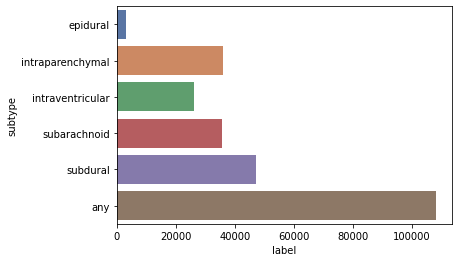

In [21]:
sns.barplot(y=count_subtypes.index, x=count_subtypes.label, palette="deep")

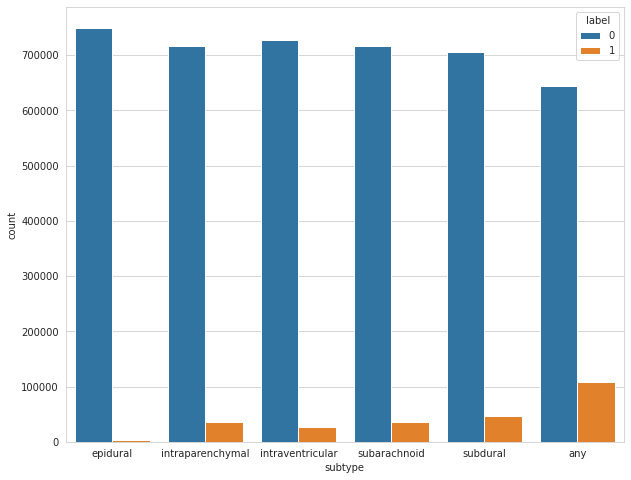

In [22]:
# subtype distribution
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
sns.countplot(x="subtype", hue="label", data=train_label)
plt.show()

In [23]:
df_corr = new_train_label_df[['epidural','intraparenchymal','intraventricular','subarachnoid','subdural']]

In [24]:
df_corr.corr()

epidural  intraparenchymal  intraventricular  subarachnoid  \
epidural          1.000000          0.047325          0.013205      0.040707   
intraparenchymal  0.047325          1.000000          0.313379      0.217744   
intraventricular  0.013205          0.313379          1.000000      0.215912   
subarachnoid      0.040707          0.217744          0.215912      1.000000   
subdural          0.044782          0.129061          0.062744      0.183088   

                  subdural  
epidural          0.044782  
intraparenchymal  0.129061  
intraventricular  0.062744  
subarachnoid      0.183088  
subdural          1.000000

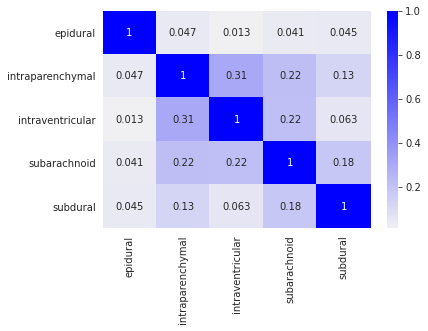

In [25]:
cmap = sns.light_palette("blue", as_cmap=True)
sns.heatmap(df_corr.corr(), annot=True, cmap=cmap)
plt.show()

<a id='hemo_Image_Folder'></a> 
## Image folder
- 데이터셋의 CT 영상은 DCM파일이며, 파일명은 다음과 같습니다.
- The name of each image is given by: `ID_[Image Id].dcm`
- Example
    - ID_4a85a3a3f.dcm
- 본 데이터셋은 모든 DICOM 파일이 한 디렉토리에 섞여 있습니다. 그래서 환자별로 나누는 작업이 필요합니다.

In [23]:
FILE_EXTENSION = ['.img', '.IMG', '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', \
                  '.PNG', '.gif', '.GIF', 'dcm', 'DCM', '.csv', '.CSV']
DCM_EXTENSION = ['.dcm', '.DCM']
IMG_EXTENSION = ['.img', '.IMG', '.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.gif', '.GIF']
PNG_EXTENSION = ['.png', '.PNG']

def check_extension(filename, extension_ls=FILE_EXTENSION):
    # filename이 해당 확장자(extension_ls)로 되어있는 경우 True
    return any(filename.endswith(extension) for extension in extension_ls)

def load_file_paths(folder_path, extension_ls=FILE_EXTENSION):
    """
    find 'extension_ls' file paths in folder.
    
    Parameters:
        folder_path (str) -- folder directory
        extension_ls (list) -- list of extensions
    
    Return:
        file_paths (list) -- list of 'extension_ls' file paths
    
    """
    
    file_paths = []
    assert os.path.isdir(folder_path), f'{folder_path} is not a valid directory'

    for root, _, fnames in sorted(os.walk(folder_path)):
        for fname in fnames:
            if check_extension(fname, extension_ls):
                path = os.path.join(root, fname)
                file_paths.append(path)
 
    return file_paths[:]

In [24]:
TRAIN_PATH = "./data/rsna-intracranial-hemorrhage-detection/stage_2_train"
train_img_paths = load_file_paths(TRAIN_PATH, DCM_EXTENSION)
train_img_paths[0]

'./data/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_00042829c.dcm'

### Data cleansing
Label과 마찬가지로 DICOM 파일도 바로 사용하지 않고 Data cleansing작업을 통해 정제합니다.

In [25]:
# 데이터 중 한 case는 열리지 않습니다. 제거하도록 합니다.
# Corrupted PixelData in ID_6431af929.dcm
# reference: https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109530
# pydicom.read_file(os.path.join(TRAIN_PATH, 'ID_6431af929.dcm')).pixel_array

`RSNA Intracranial Hemorrhage Detection` 전체 데이터셋에 대해  DICOM Header info를 DataFrame 형태로 저장하여 분석에 용이하게 만들 수 있습니다.  
참고로 이 데이터셋은 학습 데이터 수가 7279cases(대략 427GB)입니다.

### Data cleansing: DICOM header

In [26]:
KEYWORDS = ["SOPInstanceUID", "Modality", "PatientID", "StudyInstanceUID","SeriesInstanceUID", "PhotometricInterpretation"]

def generate_dicom_info_df(files_dir, keywords):
    info_dict = {}
    for name in keywords:
        info_dict[name] = []

    for file in tqdm(files_dir):
        try:
            dcm = pydicom.read_file(file, force=True)

            for name in keywords:
                try:
                    info_dict[name].append(dcm[name].value)
                except:
                    info_dict[name].append(np.nan)
        except:
            pass
    info_df = pd.DataFrame(info_dict)
    
    return info_df

In [27]:
# KEYWORDS에 해당하는 dicom info DataFrame 생성
#train_df = generate_dicom_info_df(train_img_paths, KEYWORDS)
#train_df.to_csv(os.path.join(DATAPATH, 'train_metadata.csv'), index=False)

In [28]:
DATAPATH = "./data/rsna-intracranial-hemorrhage-detection"

In [29]:
# 본 실습에서는 미리 생성하여 저장해둔 csv 파일을 이용합니다.(train_metadata.csv)
train_df = pd.read_csv(os.path.join(DATAPATH, 'train_metadata.csv'))

In [30]:
train_df

SOPInstanceUID Modality    PatientID StudyInstanceUID  \
0        ID_000012eaf       CT  ID_f15c0eee    ID_30ea2b02d4   
1        ID_000039fa0       CT  ID_eeaf99e7    ID_134d398b61   
2        ID_00005679d       CT  ID_18f2d431    ID_b5c26cda09   
3        ID_00008ce3c       CT  ID_ce8a3cd2    ID_974735bf79   
4        ID_0000950d7       CT  ID_d278c67b    ID_8881b1c4b1   
...               ...      ...          ...              ...   
752797   ID_ffff82e46       CT  ID_a85c9d08    ID_eca4bf46ac   
752798   ID_ffff922b9       CT  ID_5964c5e5    ID_b47ca0ad05   
752799   ID_ffffb670a       CT  ID_4f7414e4    ID_ffb2e70ba3   
752800   ID_ffffcbff8       CT  ID_a5382712    ID_ff0ba45814   
752801   ID_fffff9393       CT  ID_41db05df    ID_7c887292d5   

       SeriesInstanceUID PhotometricInterpretation  \
0          ID_0ab5820b2a               MONOCHROME2   
1          ID_5f8484c3e0               MONOCHROME2   
2          ID_203cd6ec46               MONOCHROME2   
3          ID_3780d48b28               MONOCHROME2   
4          ID_84296c3845               MONOCHROME2   
...                  ...                       ...   
752797     ID_3ef9b97743               MONOCHROME2   
752798     ID_6d2a9b2810               MONOCHROME2   
752799     ID_87b33b4a10               MONOCHROME2   
752800     ID_bd174db91c               MONOCHROME2   
752801     ID_dff8d8efd5               MONOCHROME2   

                           ImagePositionPatient  
0         [-125.000000, -115.897980, 77.970825]  
1         [-125.000000, -141.318451, 62.720940]  
2                 [-134.463, -110.785, -39.569]  
3               [-125, -83.0468112, 175.995344]  
4        [-126.437378, -126.437378, 157.500000]  
...                                         ...  
752797                  [-152, -56, 1011.99995]  
752798  [-126.408875, -126.408875, -235.611511]  
752799              [-125.000, -133.686, 4.725]  
752800             [-125.000, -127.453, 35.433]  
752801            [-125.000, -127.484, 140.740]  

[752802 rows x 7 columns]

In [31]:
# 빈데이터가 있는지 찾습니다. 이전에 열리지 않던 case:  ID_6431af929.dcm 가 빈데이터에 해당됩니다.
train_df.isnull().sum()

SOPInstanceUID               1
Modality                     1
PatientID                    1
StudyInstanceUID             1
SeriesInstanceUID            1
PhotometricInterpretation    1
ImagePositionPatient         1
dtype: int64

In [32]:
# 빈데이터를 제거해줍니다.(ID_6431af929.dcm)
train_df = train_df.dropna(axis=0).reset_index(drop=True)

In [33]:
train_df

SOPInstanceUID Modality    PatientID StudyInstanceUID  \
0        ID_000012eaf       CT  ID_f15c0eee    ID_30ea2b02d4   
1        ID_000039fa0       CT  ID_eeaf99e7    ID_134d398b61   
2        ID_00005679d       CT  ID_18f2d431    ID_b5c26cda09   
3        ID_00008ce3c       CT  ID_ce8a3cd2    ID_974735bf79   
4        ID_0000950d7       CT  ID_d278c67b    ID_8881b1c4b1   
...               ...      ...          ...              ...   
752796   ID_ffff82e46       CT  ID_a85c9d08    ID_eca4bf46ac   
752797   ID_ffff922b9       CT  ID_5964c5e5    ID_b47ca0ad05   
752798   ID_ffffb670a       CT  ID_4f7414e4    ID_ffb2e70ba3   
752799   ID_ffffcbff8       CT  ID_a5382712    ID_ff0ba45814   
752800   ID_fffff9393       CT  ID_41db05df    ID_7c887292d5   

       SeriesInstanceUID PhotometricInterpretation  \
0          ID_0ab5820b2a               MONOCHROME2   
1          ID_5f8484c3e0               MONOCHROME2   
2          ID_203cd6ec46               MONOCHROME2   
3          ID_3780d48b28               MONOCHROME2   
4          ID_84296c3845               MONOCHROME2   
...                  ...                       ...   
752796     ID_3ef9b97743               MONOCHROME2   
752797     ID_6d2a9b2810               MONOCHROME2   
752798     ID_87b33b4a10               MONOCHROME2   
752799     ID_bd174db91c               MONOCHROME2   
752800     ID_dff8d8efd5               MONOCHROME2   

                           ImagePositionPatient  
0         [-125.000000, -115.897980, 77.970825]  
1         [-125.000000, -141.318451, 62.720940]  
2                 [-134.463, -110.785, -39.569]  
3               [-125, -83.0468112, 175.995344]  
4        [-126.437378, -126.437378, 157.500000]  
...                                         ...  
752796                  [-152, -56, 1011.99995]  
752797  [-126.408875, -126.408875, -235.611511]  
752798              [-125.000, -133.686, 4.725]  
752799             [-125.000, -127.453, 35.433]  
752800            [-125.000, -127.484, 140.740]  

[752801 rows x 7 columns]

앞서 다뤘듯이 모든 DICOM 파일이 한 디렉토리에 섞여 있습니다.  
환자별로 나누는 작업을 수행합니다.
환자별로 나누는 이유는 train/validation/test로 원활히 나누기 위함입니다.

In [34]:
# DICOM Header info 중 StudyInstanceUID가 같은 것끼리 나눌 때는 잘 안나눠집니다.
train_df.groupby('PatientID')['StudyInstanceUID'].count().sort_values()

PatientID
ID_11e103d4     20
ID_b956c8dd     20
ID_929a5b39     20
ID_61fd9f22     21
ID_7001adfb     22
              ... 
ID_39d7d875    377
ID_24df80e7    384
ID_5e035492    384
ID_d2deede6    465
ID_268b38fe    548
Name: StudyInstanceUID, Length: 18938, dtype: int64

In [35]:
# 동일한 작업을 SeriesInstanceUID로 수행했을 때 잘 분리됩니다.
train_df.groupby('SeriesInstanceUID')['SeriesInstanceUID'].count().sort_values()

SeriesInstanceUID
ID_5525208af5    20
ID_3029272c0e    20
ID_3c252209e2    20
ID_6d18bc0792    21
ID_fdc02e8b95    22
                 ..
ID_f34a7f59e1    60
ID_852fede48b    60
ID_61fbfea53d    60
ID_d9cd7645e1    60
ID_2671dae30e    60
Name: SeriesInstanceUID, Length: 21744, dtype: int64

In [36]:
slices_by_series = train_df.groupby('SeriesInstanceUID')['SOPInstanceUID'].apply(lambda x: "%s" % ','.join(x))

In [37]:
# SeriesInstanceUID 기준으로 list 출력
series_ls = [slices.split(',') for slices in slices_by_series.values]
print("train dataset에 대한 전체 CT case 수: {}".format(len(series_ls)))

train dataset에 대한 전체 CT case 수: 21744


### Data Preprocessing
모델 학습에 용이하도록 CT를 전처리하는 방법에 대해 다룹니다.

In [38]:
def set_outside_scanner_to_air(hu_pixelarrays):
    """
    Pixel Padding Value Attribute(0028,0120) -> air
    """
    hu_pixelarrays[hu_pixelarrays < -1024] = -1024
    
    return hu_pixelarrays

In [39]:
def transform_to_hu(dicom_info, image):
    image = set_outside_scanner_to_air(image)
    
    intercept = dicom_info.RescaleIntercept
    slope = dicom_info.RescaleSlope
    hu_image = image.astype(np.float64) * slope + intercept
    hu_image = set_outside_scanner_to_air(hu_image.astype(np.int16))
    return hu_image

In [40]:
def ct_img_loader(dcm_path):
    """
    Function of Loading CT-scan
    patient path to CT slices(HU)
    
    Parameters:
        dcm_path (str) -- dicom file path
    
    Return:
        dcm_img (np.array) -- CT slice(HU)
    """
    # force=True : reading even if no File Meta Information header is found
    dcm_info = pydicom.read_file(dcm_path, force=True)
    tmp_img = dcm_info.pixel_array
    dcm_img = transform_to_hu(dcm_info, tmp_img)
    
    return dcm_img

In [41]:
example_path = train_img_paths[0]
hu_ct_img = ct_img_loader(example_path)

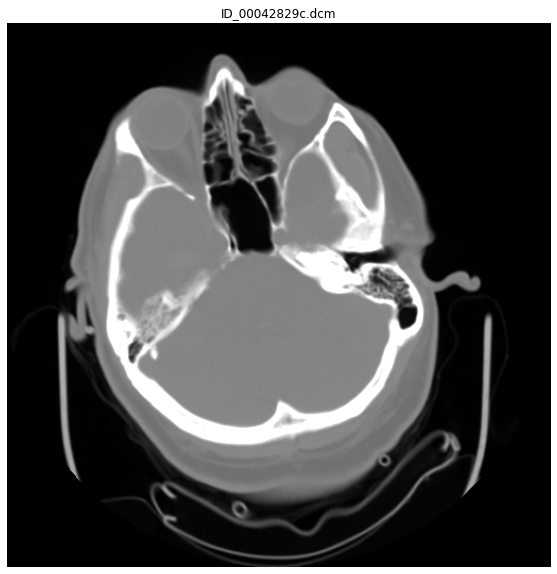

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(hu_ct_img, vmin=-1000, vmax=1000, cmap='gray')
plt.axis("off")
plt.title(example_path.split('/')[-1])
plt.show()

In [43]:
class CT_Windowing:
    """
    CT image windowing : WL_Window Level, WW_Window Width
    """
   
    def __init__(self, mode='custom', custom_window=None, norm=False):
        """
        Parameters:
            mode (str)(WL|WW) -- 
                'abdomen'(60|400) , 'bone'(300|1500), 'brain'(40|80), 
                'chest'(40|400), 'lung'(-700|1500), 'custom'(WL|WW)
            custom_window (list or tuple) -- 
                if mode == 'custom', set custom_window(WL, WW)
            norm (bool) -- normalize to uint8 (0~255)

        """
        option = ['abdomen' , 'bone', 'brain', 'chest', 'lung', 'subdural', 'custom']
        assert mode in option, "Wrong mode: Enter \'abdomen\' , \'bone\', \
                                \'brain\', \'chest\', \'lung\', \'subdural\', \'custom\'"
        
        self.mode = "window_" + mode
        if custom_window is not None:
            self.w_level = custom_window[0]
            self.w_width = custom_window[1]
            
        self.norm = norm
        
    def windowing(self):
        self.w_min = self.w_level - (self.w_width / 2)
        self.w_max = self.w_level + (self.w_width / 2)
        window_image = self.img.copy()
        window_image[window_image < self.w_min] = self.w_min
        window_image[window_image > self.w_max] = self.w_max
        
        if self.norm:
            window_image = np.uint8(((window_image - self.w_min) / \
                                     (self.w_max - self.w_min)) * 255.0)
        return window_image
        
    def window_abdomen(self):
        self.w_level = 60
        self.w_width = 400
        
        return self.windowing()
        
    def window_bone(self):
        self.w_level = 300
        self.w_width = 1500
        
        return self.windowing()
    
    def window_brain(self):
        self.w_level = 40
        self.w_width = 80
        
        return self.windowing()
    
    def window_chest(self):
        self.w_level = 40
        self.w_width = 400
        
        return self.windowing()
        
    def window_lung(self):
        #SNUH version
        self.w_level = -700
        self.w_width = 1500
        
        return self.windowing()
    
    def window_subdural(self):
        # RSNA Intrracranial Hemorrhage : See like a Radiologist with Systematic Windowing
        # https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing
        self.w_level = 80
        self.w_width = 200
        
        return self.windowing()
        
    def window_custom(self):
        return self.windowing()
    
    def __call__(self, hu_img):
        self.img = hu_img
        self.opt = getattr(self, self.mode, lambda:'custom')
        return self.opt()  

In [44]:
def sample_stack(stack, rows=3, cols=3, start_with=0, show_every=1, vmin=-1000, vmax=1000):
    fig,ax = plt.subplots(rows,cols,figsize=[20,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols),int(i % cols)].set_title(f'slice {ind}')
        ax[int(i/cols),int(i % cols)].imshow(stack[ind], vmin=vmin, vmax=vmax, cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

In [45]:
# stacking img
# N : num of img
N=9
sample_imgs = np.stack([ct_img_loader(p) for p in train_img_paths[:N]])

In [46]:
sample_imgs.shape

(9, 512, 512)

In [47]:
brain_window_fn = CT_Windowing(mode='brain', norm=True)
sample_brainw_img = brain_window_fn(sample_imgs)

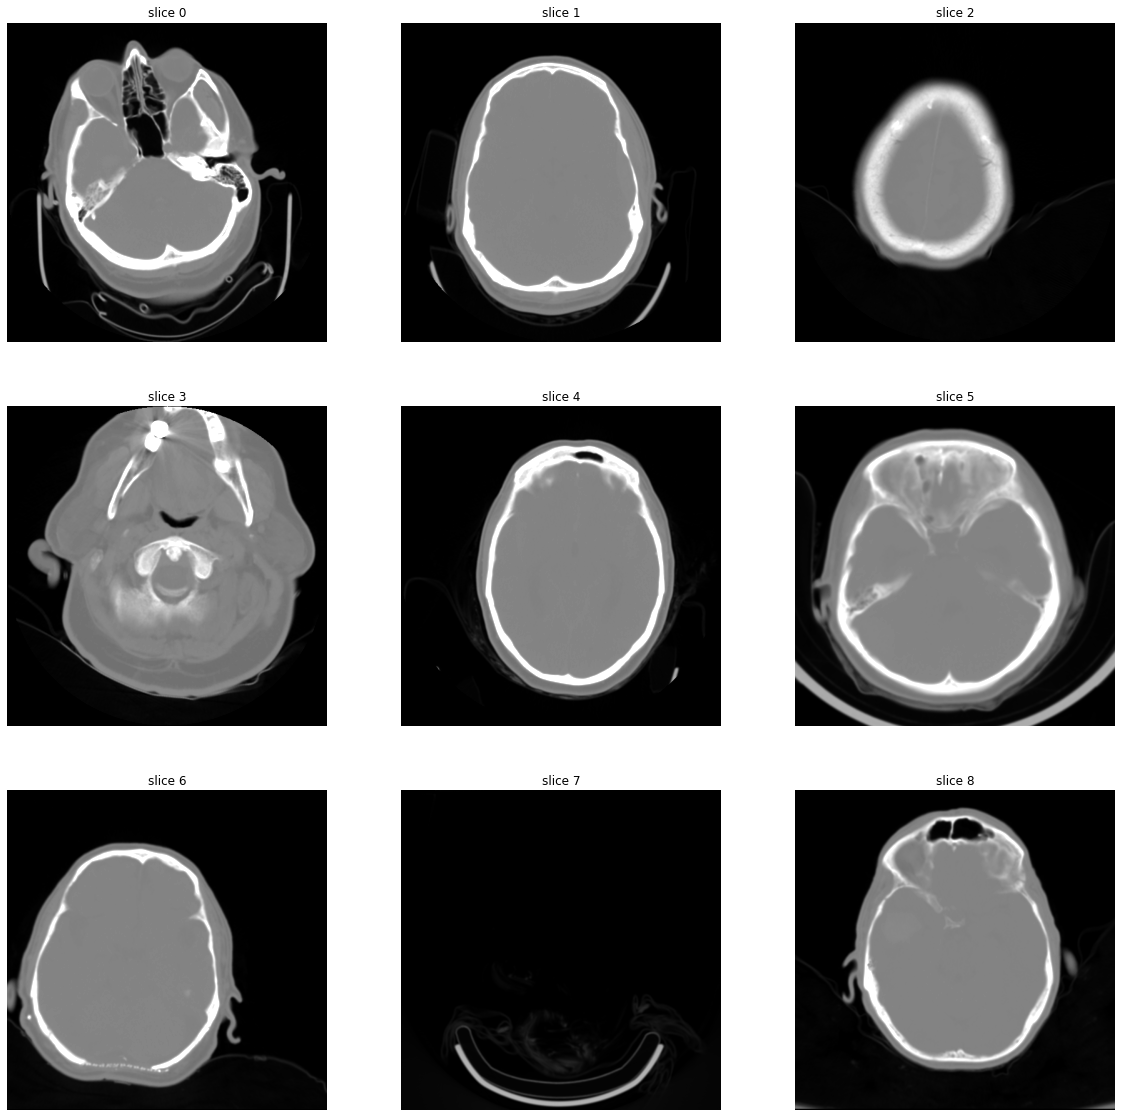

In [48]:
sample_stack(sample_imgs)

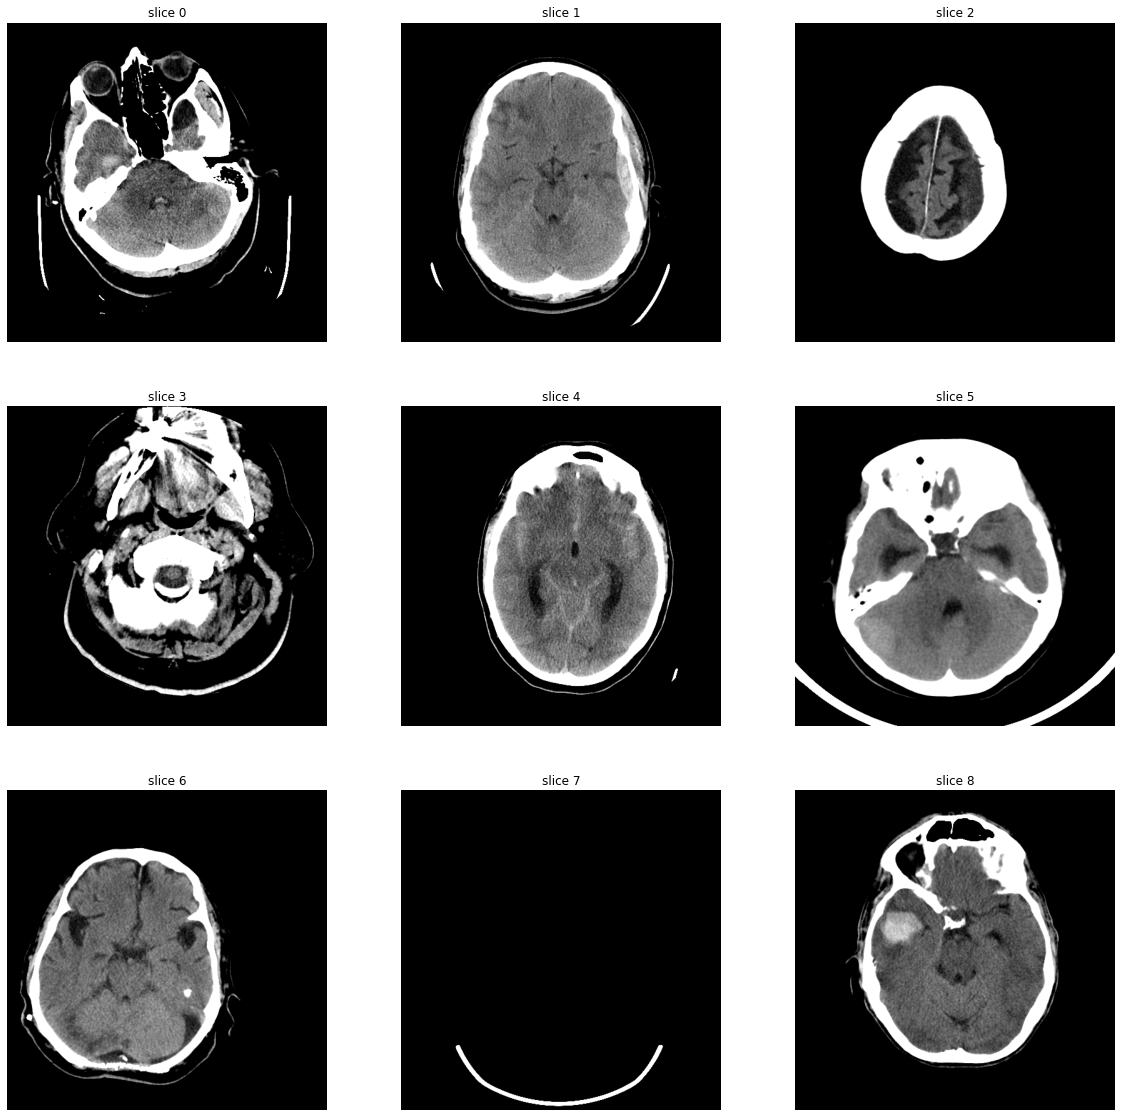

In [49]:
sample_stack(sample_brainw_img, vmin=0, vmax=255)

### Why subdural hematomas are tricky
CT 데이터 기반 딥러닝 모델 학습 시 전처리 과정에 window setting이 필요한지에 대해선 의견이 분분합니다.  
그 중 필요하다는 의견에 뒷받침되는 근거로, subdural window setting에 관련된 내용이 있습니다.  
reference: https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing

In [50]:
trainpath = "./data/rsna-intracranial-hemorrhage-detection/stage_2_train"
case = os.path.join(trainpath,'ID_9d9cc6b01.dcm')

In [51]:
case_img = ct_img_loader(case) 

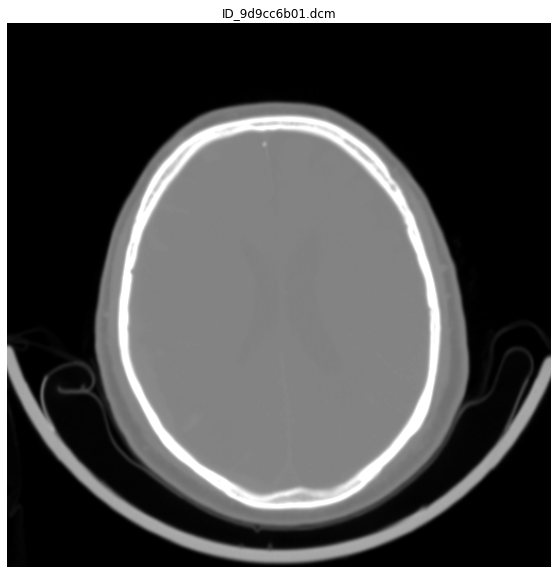

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(case_img, vmin=-1000, vmax=1000, cmap='gray')
plt.axis("off")
plt.title(case.split('/')[-1])
plt.show()

In [53]:
brain_window_fn = CT_Windowing(mode='brain', norm=True)
subdural_window_fn = CT_Windowing(mode='subdural', norm=True)
brainw_case_img = brain_window_fn(case_img)
subduralw_case_img = subdural_window_fn(case_img)

(-0.5, 511.5, 511.5, -0.5)

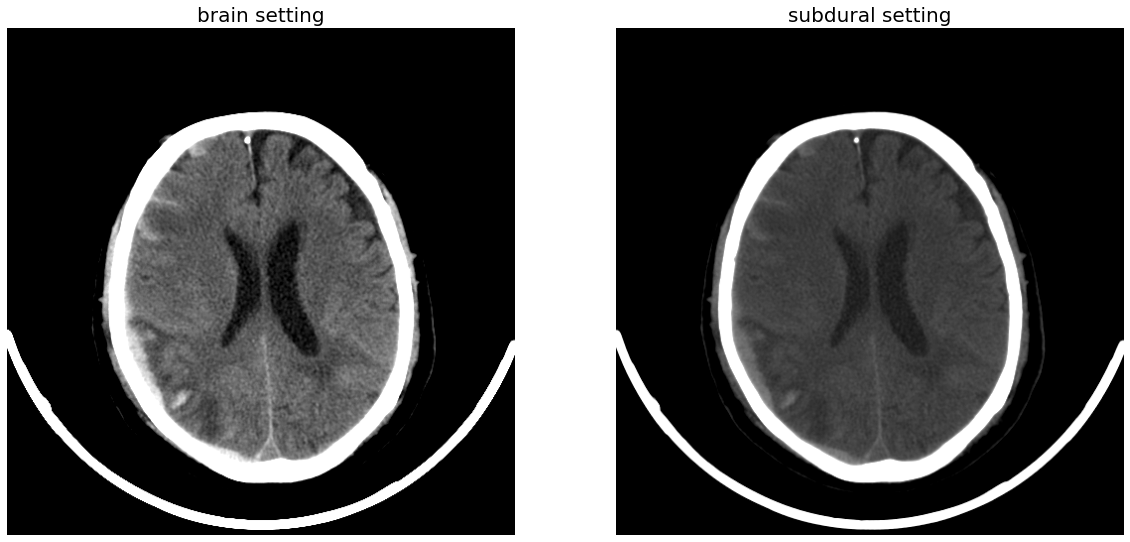

In [54]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(brainw_case_img, vmin=0, vmax=255, cmap="gray")
ax[0].set_title('brain setting', fontsize=20)
ax[0].axis("off")
ax[1].imshow(subduralw_case_img, vmin=0, vmax=255, cmap='gray')
ax[1].set_title('subdural setting', fontsize=20)
ax[1].axis("off")